In [19]:
# 1. Install library
!pip -q install -U scikit-learn Sastrawi wordcloud emoji matplotlib pandas openpyxl transformers torch

import re, os, emoji, string, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm

plt.rcParams["figure.dpi"] = 150
OUTDIR = "/content/fintech_battle_outputs"
os.makedirs(OUTDIR, exist_ok=True)


In [20]:
# 2. Upload & load data
from google.colab import files
print("Upload dana.csv dan ovo.csv")
_ = files.upload()

dana = pd.read_csv("dana.csv")
ovo  = pd.read_csv("ovo.csv")

dana["app"] = "DANA"
ovo["app"]  = "OVO"

df = pd.concat([dana, ovo], ignore_index=True)
df = df.rename(columns={c:c.strip().lower() for c in df.columns})
df = df[["created_at","score","content","thumbsupcount","app"]].dropna(subset=["content"])
df.head()


Upload dana.csv dan ovo.csv


Saving dana.csv to dana.csv
Saving ovo.csv to ovo.csv


,created_at,score,content,thumbsupcount,app
0,10/25/2024 9:38,1,Semenjak diupdate performa aplikasi jadi menur...,145,DANA
1,10/20/2024 4:51,2,"Semenjak baru update ulang, transaksi menjadi ...",177,DANA
2,10/19/2024 8:18,2,"Semenjak terupdate akun jadi keluar sendiri, d...",220,DANA
3,10/11/2024 13:53,1,"Aneh, gampang banget buat org login, mau pake ...",515,DANA
4,10/22/2024 18:02,1,"Komplain pun di permainkan CS, berkali2 nelpon...",140,DANA


In [21]:
# 3. Cleaning teks (ringan, biar cepat)
punct_tbl = str.maketrans("", "", string.punctuation)

def clean_text_light(s):
    s = str(s).lower()
    s = emoji.replace_emoji(s, replace=" ")
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"@[A-Za-z0-9_]+", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = s.translate(punct_tbl)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["clean"] = df["content"].astype(str).apply(clean_text_light)
df[["app","content","clean"]].head(10)


,app,content,clean
0,DANA,Semenjak diupdate performa aplikasi jadi menur...,semenjak diupdate performa aplikasi jadi menur...
1,DANA,"Semenjak baru update ulang, transaksi menjadi ...",semenjak baru update ulang transaksi menjadi l...
2,DANA,"Semenjak terupdate akun jadi keluar sendiri, d...",semenjak terupdate akun jadi keluar sendiri da...
3,DANA,"Aneh, gampang banget buat org login, mau pake ...",aneh gampang banget buat org login mau pake ke...
4,DANA,"Komplain pun di permainkan CS, berkali2 nelpon...",komplain pun di permainkan cs berkali2 nelpon ...
5,DANA,Kayaknya aplikasi dana sudah gak ada fitur not...,kayaknya aplikasi dana sudah gak ada fitur not...
6,DANA,"3x saldo saya hilang, tanpa mengklik link, tid...",3x saldo saya hilang tanpa mengklik link tidak...
7,DANA,Ram 8Gb Internal 216 Gb terpakai 12Gb Jaringan...,ram 8gb internal 216 gb terpakai 12gb jaringan...
8,DANA,Yah ada kendala pada proses ini coba lagi nant...,yah ada kendala pada proses ini coba lagi nant...
9,DANA,"Buka aplikasinya lama sekali, untuk cek riwaya...",buka aplikasinya lama sekali untuk cek riwayat...


In [22]:
# 4. Auto-label Sentiment pakai IndoBERT
MODEL_ID = "w11wo/indonesian-roberta-base-sentiment-classifier"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID).to(device)
id2label = model.config.id2label  # {0:'negative',1:'neutral',2:'positive'}

texts = df["clean"].astype(str).fillna("").tolist()

def predict_sentiment_batched(texts, batch_size=128, max_len=256):
    out_labels = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_len,
                        return_tensors="pt").to(device)
        with torch.no_grad():
            logits = model(**enc).logits
        pred_ids = torch.argmax(logits, dim=1).cpu().numpy().tolist()
        out_labels.extend([id2label[j].lower() for j in pred_ids])
    return out_labels

df["sentiment"] = predict_sentiment_batched(texts)
df["sentiment"].value_counts()


  0%|          | 0/1482 [00:00<?, ?it/s]

,count
sentiment,
negative,125270
positive,36518
neutral,27859


In [23]:
# 5. Split data & TF-IDF (limit fitur biar cepat)
X_train, X_test, y_train, y_test = train_test_split(
    df["clean"], df["sentiment"],
    test_size=0.2, random_state=42, stratify=df["sentiment"]
)

tfidf = TfidfVectorizer(
    ngram_range=(1,1),   # unigram
    max_df=0.95,
    min_df=10,
    max_features=30000   # limit fitur
)
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)


In [24]:
# 6. Train model (RandomForest versi cepat)
best_rf = RandomForestClassifier(
    n_estimators=150,          # dikurangi biar cepat
    max_depth=25,              # batasi kedalaman
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    verbose=2
).fit(Xtr, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 150building tree 2 of 150

building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.4s


building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72 of 150
building tree 73 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 150
building tree 79 of 150
building tree 80 of 150
building tree 81

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.0min finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    1.0s finished


Classification Report – RF vs IndoBERT labels
              precision    recall  f1-score   support

    negative      0.920     0.822     0.868     25054
     neutral      0.538     0.705     0.610      5572
    positive      0.777     0.878     0.825      7304

    accuracy                          0.815     37930
   macro avg      0.745     0.802     0.768     37930
weighted avg      0.836     0.815     0.822     37930



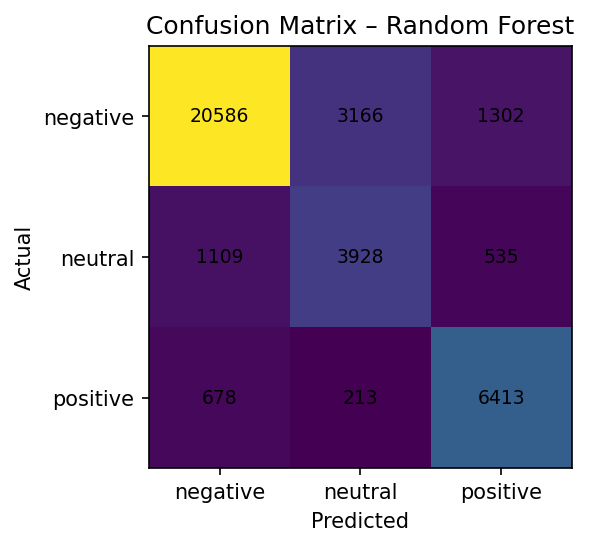

In [25]:
# 7. Evaluasi
y_pred = best_rf.predict(Xte)

print("Classification Report – RF vs IndoBERT labels")
print(classification_report(y_test, y_pred, digits=3))

order = ["negative","neutral","positive"]
cm = confusion_matrix(y_test, y_pred, labels=order)

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix – Random Forest")
ax.set_xticks(range(3)); ax.set_yticks(range(3))
ax.set_xticklabels(order); ax.set_yticklabels(order)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=9)
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/confusion_matrix_rf.png", dpi=300)
plt.show()

# Simpan classification report
rep = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(rep).T.to_csv(f"{OUTDIR}/classification_report_rf.csv")


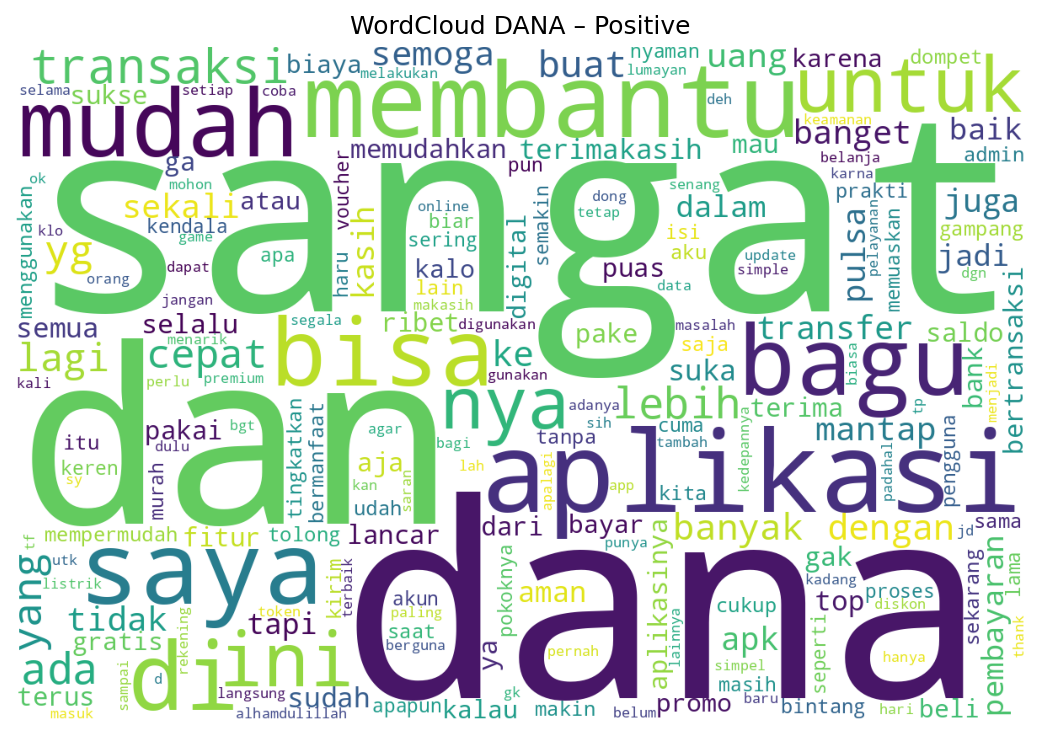

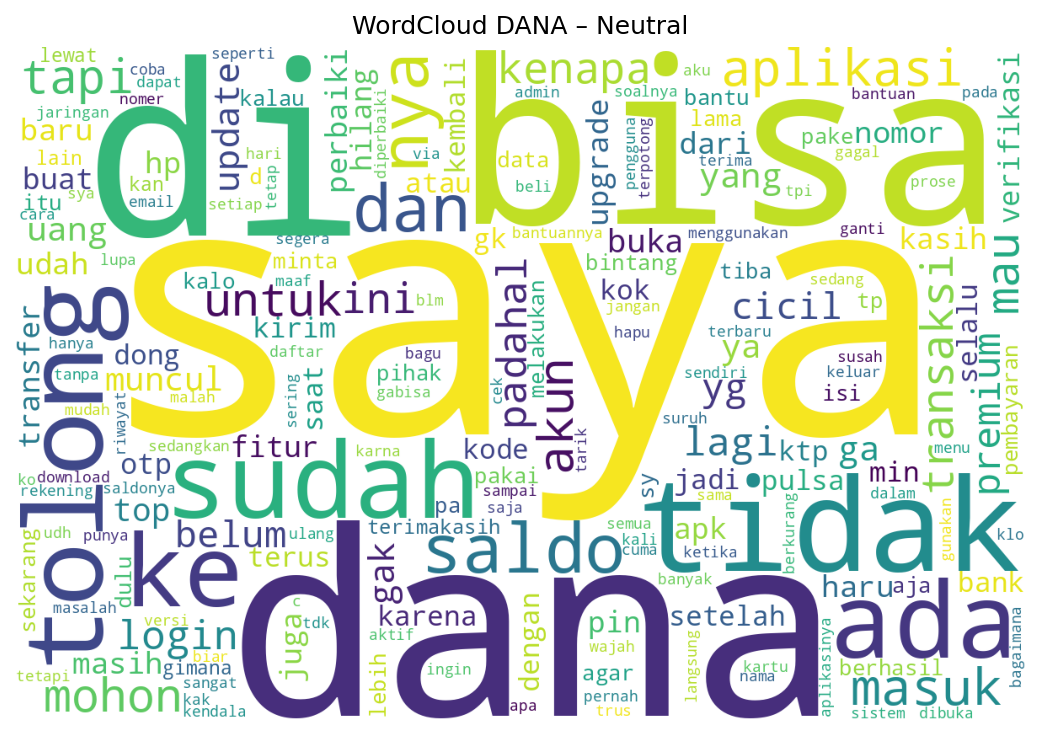

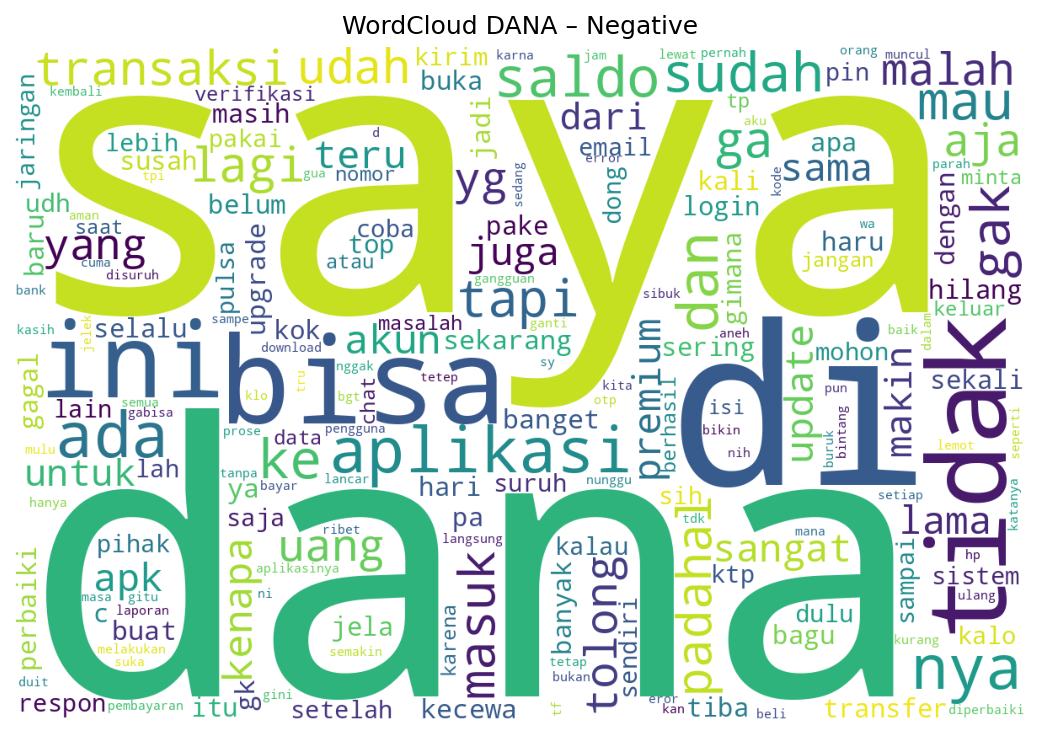

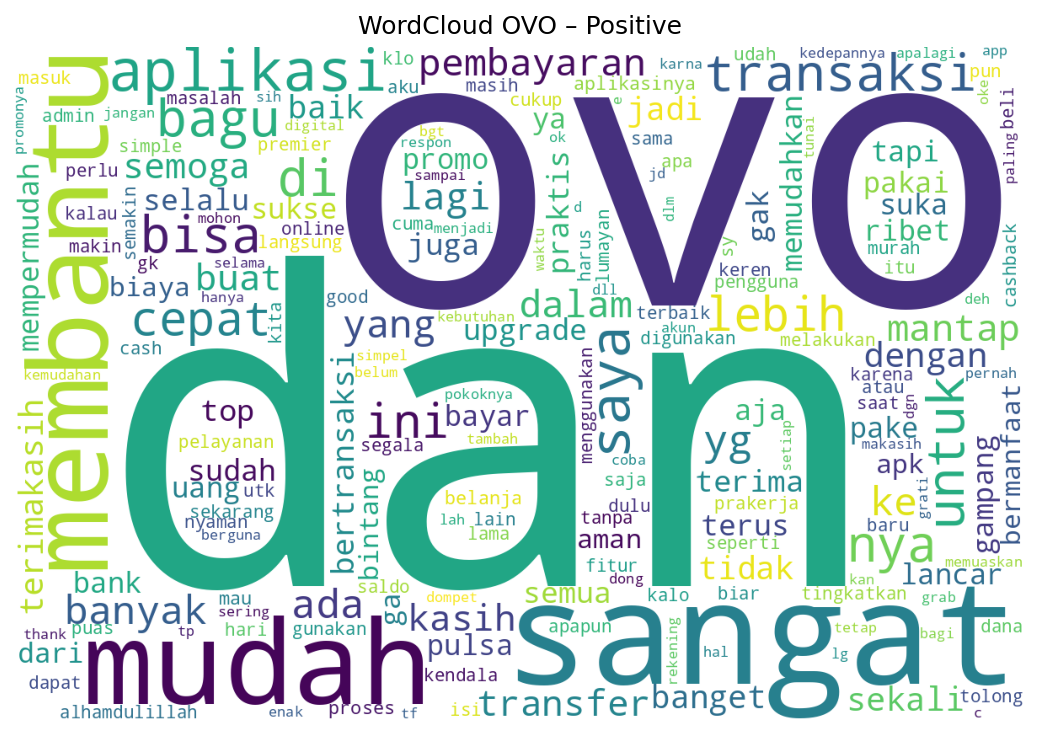

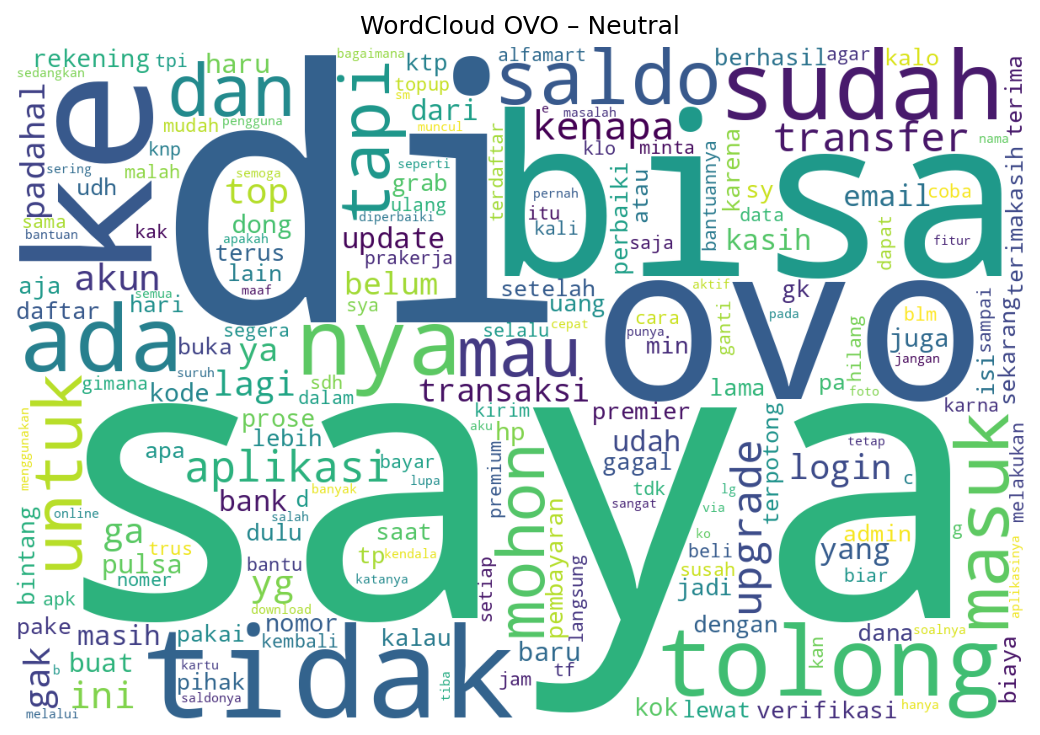

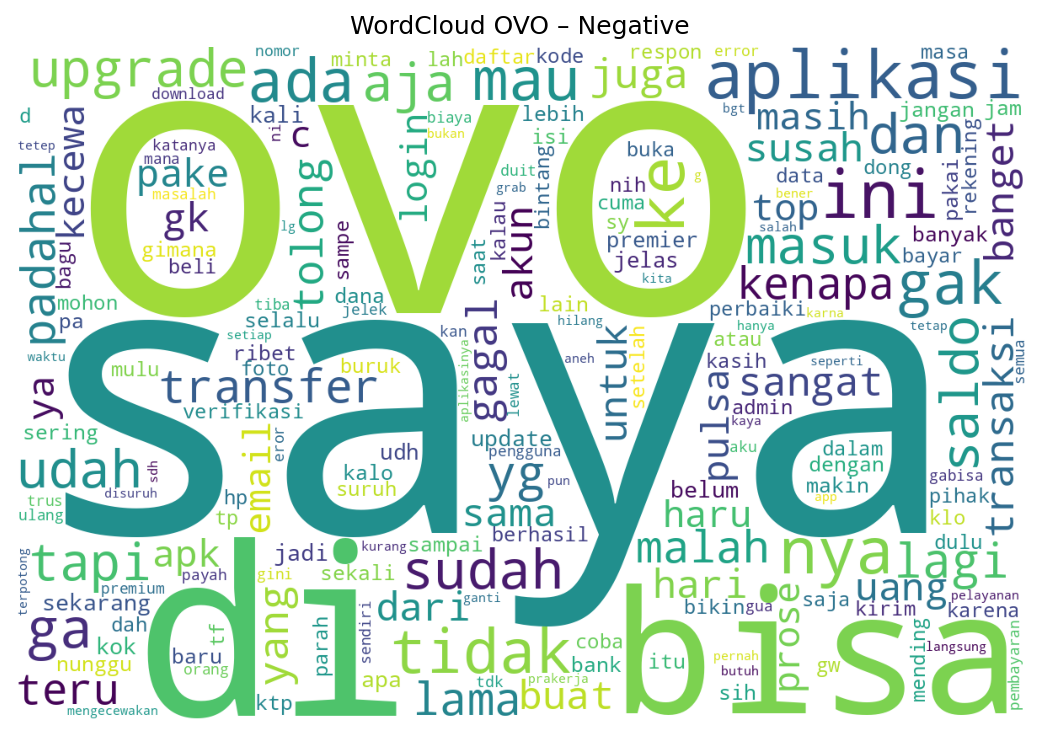

In [26]:
# 8. WordCloud per app & sentiment
def wordcloud_by(sub, title, fname):
    text = " ".join(sub["clean"].tolist())
    if not text.strip(): return
    wc = WordCloud(width=1200, height=800, background_color="white", collocations=False).generate(text)
    plt.figure(figsize=(8,5)); plt.imshow(wc); plt.axis("off"); plt.title(title)
    plt.tight_layout(); plt.savefig(f"{OUTDIR}/{fname}.png", dpi=300); plt.show()

for app in ["DANA","OVO"]:
    for sent in ["positive","neutral","negative"]:
        subset = df[(df["app"]==app) & (df["sentiment"]==sent)]
        if len(subset) >= 20:
            wordcloud_by(subset, f"WordCloud {app} – {sent.title()}", f"wc_{app}_{sent}")


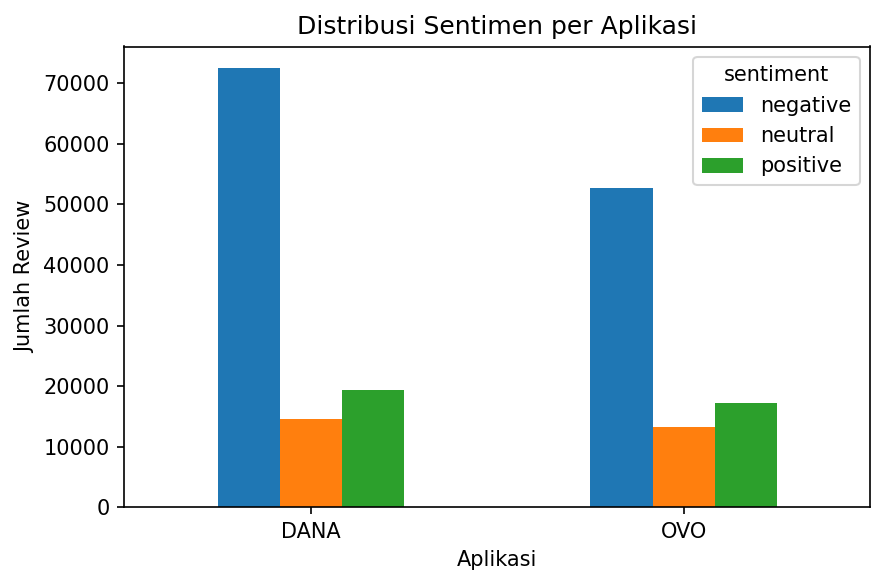

sentiment,negative,neutral,positive
app,,,
DANA,72483,14614,19368
OVO,52787,13245,17150


In [27]:
# 9. Distribusi sentimen per aplikasi
ct = pd.crosstab(df["app"], df["sentiment"]).reindex(
    index=["DANA","OVO"], columns=["negative","neutral","positive"]
).fillna(0)

ax = ct.plot(kind="bar", figsize=(6,4))
plt.title("Distribusi Sentimen per Aplikasi")
plt.xlabel("Aplikasi"); plt.ylabel("Jumlah Review")
plt.xticks(rotation=0); plt.tight_layout()
plt.savefig(f"{OUTDIR}/distribusi_sentimen.png", dpi=300)
plt.show()

ct


In [28]:
# 10. (Optional) Top keywords per sentiment (buat insight tambahan)
X_all = tfidf.transform(df["clean"])
for lab in ["negative","neutral","positive"]:
    idx = (df["sentiment"]==lab).values
    if idx.sum() == 0: continue
    avg = np.asarray(X_all[idx].mean(axis=0)).ravel()
    top_idx = avg.argsort()[-15:][::-1]
    vocab = np.array(tfidf.get_feature_names_out())[top_idx]
    print(f"\nTop terms – {lab}:")
    print(", ".join(vocab))



Top terms – negative:
saya, di, bisa, dana, tidak, aplikasi, nya, ini, gak, ada, mau, ga, ke, saldo, masuk

Top terms – neutral:
saya, bisa, di, dana, tidak, tolong, ke, sudah, saldo, ovo, masuk, mohon, cicil, ada, nya

Top terms – positive:
sangat, membantu, dan, mudah, bagus, cepat, aplikasi, untuk, transaksi, mantap, lebih, ovo, dana, nya, saya
